In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
import arviz as az
import pymc as pm
from sklearn.metrics import roc_curve, roc_auc_score


In [2]:
project_dir = r'./sample_data'
os.chdir(project_dir)



In [3]:
directory_contents = os.listdir()

print(directory_contents)


['anscombe.json', 'README.md', 'california_housing_test.csv', 'california_housing_train.csv', 'mnist_test.csv', 'mnist_train_small.csv']


In [6]:
merged4 = pd.read_csv('merged4.csv')

In [127]:
merged4

,defender_carrier_dist,defender_distance_to_football,rho,force,TME,tackle_event,total_energy,is_defensive_player
0,11.013632,9.256266,136.06768,418.07892,-0.166554,0,129.529087,1
1,10.246878,8.688046,195.32296,486.11276,0.290935,0,229.789344,1
2,9.464486,8.500617,242.50772,460.87440,-0.306490,0,322.187614,1
3,8.646531,8.557009,296.27640,424.66284,-0.697373,0,449.600623,1
4,7.812074,8.590053,334.68260,350.04508,0.459627,0,551.141015,1
...,...,...,...,...,...,...,...,...
643267,35.737231,36.223093,174.75540,231.45795,-0.163341,0,170.659866,1
643268,17.190352,17.293376,171.03720,218.44425,0.263773,0,169.985896,1
643269,16.632742,17.128135,171.96675,184.05090,0.265207,0,169.814775,1
643270,16.284747,16.886089,171.96675,157.09395,0.265207,0,168.372402,1


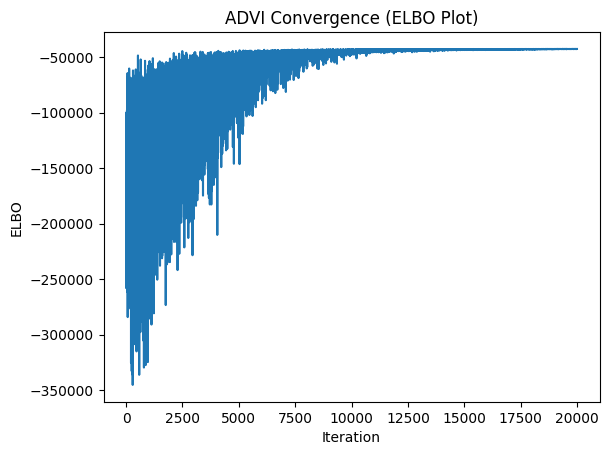

In [25]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

X = merged4[['defender_carrier_dist', 'defender_distance_to_football', 'rho', 'force', 'TME', 'total_energy']].values
y = merged4['tackle_event'].values

# Standardize the predictors
X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

with pm.Model() as model_tackle_event:
    # Priors for the intercept and coefficients
    β = pm.Normal("β", mu=0, sigma=2, shape=X_std.shape[1])
    β_0 = pm.Normal("β_0", mu=0, sigma=2)

    # Linear combination of predictors
    μ = β_0 + pm.math.dot(X_std, β)

    # Sigmoid link function
    θ = pm.math.sigmoid(μ)

    # Observations
    y_obs = pm.Bernoulli("y_obs", p=θ, observed=y)
    log_likelihood = pm.Deterministic('log_likelihood', pm.logp(y_obs, y))

    # ADVI
    advi_fit = pm.fit(method='advi', n=20000)  # Number of iterations can be adjusted

# Elbow plot
elbo = -np.array(advi_fit.hist)
plt.plot(elbo)
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.title('ADVI Convergence (ELBO Plot)')
plt.show()

# Extracting the variational posterior
trace_tackle_event = advi_fit.sample(draws=1000)


In [ ]:
az.plot_posterior(trace_tackle_event)
az.plot_trace(trace_tackle_event)

In [ ]:
trace_tackle_event = advi_fit.sample(draws=1000)

# Generate rank plots for the parameters directly from the PyMC trace
az.plot_rank(trace_tackle_event, var_names=["β", "β_0"])
plt.show()



In [28]:
from sklearn.model_selection import train_test_split
X_merged4 = merged4.drop(['tackle_event', 'is_defensive_player'], axis=1)  # Predictor variables
y_merged4 = merged4['tackle_event']  # Response variable
X_train, X_test, y_train, y_test = train_test_split(X_merged4, y_merged4, test_size=0.3, random_state=42)


In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(118039, 6)
(50589, 6)
(118039,)
(50589,)


In [33]:
trace_tackle_event.keys

<bound method Mapping.keys of Inference data with groups:
	> posterior
	> observed_data>

In [26]:
# PSIS-LOO calculation
loo = pm.loo(trace_tackle_event, model_tackle_event)

# Print the LOO summary
print(loo)


TypeError: ignored

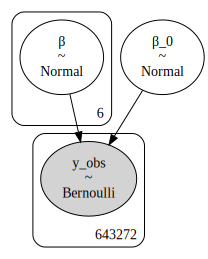

In [ ]:
with model_tackle_event:
    dag = pm.model_to_graphviz()

# Display the graph
dag

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming your model is defined and ADVI fitting is completed as shown in your snippet

# Standardize the test data using the mean and standard deviation of the training data
X_test_std = (X_test - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

with model_tackle_event:
    # Generate posterior predictive samples for the test set
    ppc = pm.sample_posterior_predictive(trace_tackle_event)


In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np


predicted_probs = ppc.posterior_predictive.y_obs.mean(dim=["chain", "draw"]).values
predicted_probs = np.ravel(predicted_probs)

print(predicted_probs); print('predicted lengths = ', len(predicted_probs));
print('\n');
print(y_test); print('test lengths = ', len(y_test))

[0.119 0.138 0.116 ... 0.063 0.048 0.056]
predicted lengths =  643272


158793    0
102923    0
60969     0
534674    0
368515    0
         ..
287934    0
43397     0
307254    0
143862    0
638899    0
Name: tackle_event, Length: 192982, dtype: int64
test lengths =  192982


In [ ]:

X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_merged4, y_merged4, np.arange(len(y_merged4)), test_size=0.3, random_state=42)

predicted_probs_test = predicted_probs[test_indices]

#check lengths to make sure compatible
print(len(predicted_probs_test), len(y_test))

# AUC
if len(predicted_probs_test) == len(y_test):
    fpr, tpr, _ = roc_curve(y_test, predicted_probs_test)
    roc_auc = auc(fpr, tpr)
    print('ROC: ', roc_auc)
else:
    print("The lengths of predicted probabilities and test labels still do not match.")


192982 192982
ROC:  0.6297332332797015


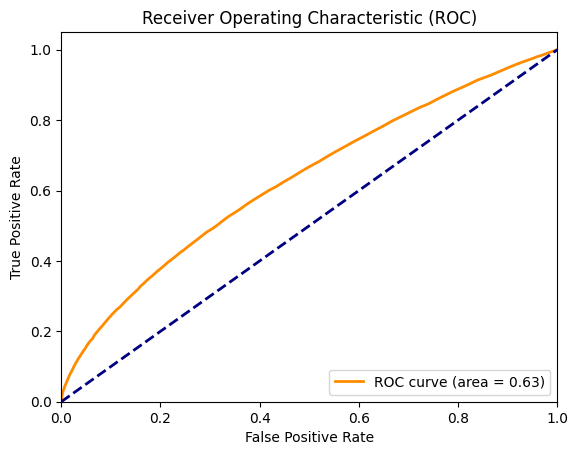

In [ ]:
import matplotlib.pyplot as plt

# ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predicted_probs_test' contains the predicted probabilities for the test set
# Apply a threshold of 0.25 to get binary predictions
threshold = 0.25
predicted_classes = (predicted_probs_test > threshold).astype(int)

# Plot the observed vs predicted data
plt.figure(figsize=(10, 6))

# Plotting the observed data
plt.hist(y_test, bins=30, alpha=0.5, label='Observed Data', color='blue')

# Plotting the predicted data
plt.hist(predicted_classes, bins=30, alpha=0.5, label='Predicted Data', color='orange')

plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.legend()
plt.title('Posterior Predictive Checks: Observed vs Predicted with 0.25 Threshold')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# using low threshold now we know how the roc looks
threshold = 0.23
predicted_classes = (predicted_probs_test > threshold).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Pooled Logit: Confusion Matrix (Threshold 0.25)')
plt.show()


In [ ]:
import arviz as az

# Assuming the rest of your code and the 'trace_tackle_event' object are already defined

# Convert the trace to ArviZ's InferenceData format
idata_tackle_event = az.convert_to_inference_data(trace_tackle_event)

# Calculate Effective Sample Size
ess = az.ess(idata_tackle_event)
print("Effective Sample Size (ESS):\n", ess)


Effective Sample Size (ESS):
 <xarray.Dataset>
Dimensions:  (β_dim_0: 6)
Coordinates:
  * β_dim_0  (β_dim_0) int64 0 1 2 3 4 5
Data variables:
    β        (β_dim_0) float64 981.5 875.9 906.9 1.002e+03 832.8 976.6
    β_0      float64 871.2


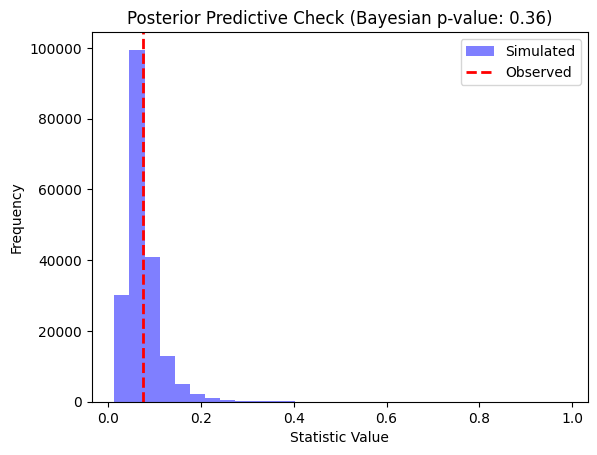

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Access the posterior predictive samples
simulated_data = ppc.posterior_predictive.y_obs.values

# Calculate the mean across the 'chain' and 'draw' dimensions
# This gives us a single predicted outcome for each observation
predicted_means = simulated_data.mean(axis=(0, 1))

# Assuming that you have a way to align these predicted probabilities with your test set
# Extract the subset of 'predicted_means' that corresponds to 'y_test'
# Let's use the test indices to extract the relevant predictions
predicted_means_test = predicted_means[test_indices]

# Proceed to calculate Bayesian p-value
observed_statistic = np.mean(y_test)
simulated_statistics = [np.mean(simulation) for simulation in predicted_means_test]

# Calculate the proportion of simulated statistics that are more extreme than the observed statistic
p_value = np.mean([s > observed_statistic for s in simulated_statistics])

# Plotting
plt.hist(simulated_statistics, bins=30, alpha=0.5, label='Simulated', color='blue')
plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed')
plt.xlabel('Statistic Value')
plt.ylabel('Frequency')
plt.title(f'Posterior Predictive Check (Bayesian p-value: {p_value:.2f})')
plt.legend()
plt.show()


In [149]:
with model_tackle_event:
    # Generate posterior predictive samples for the test set
    ppc = pm.sample_posterior_predictive(trace_tackle_event)

In [151]:
print(ppc.keys)

<bound method Mapping.keys of Inference data with groups:
	> >


/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


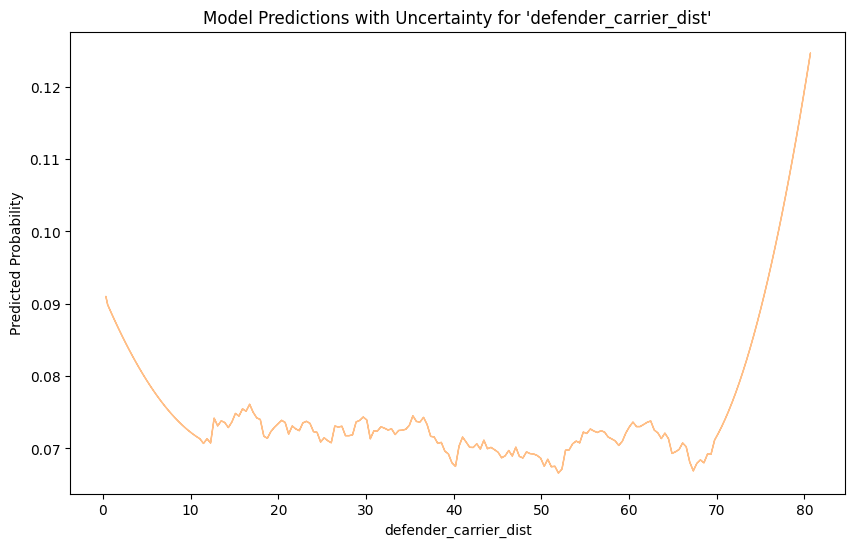

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


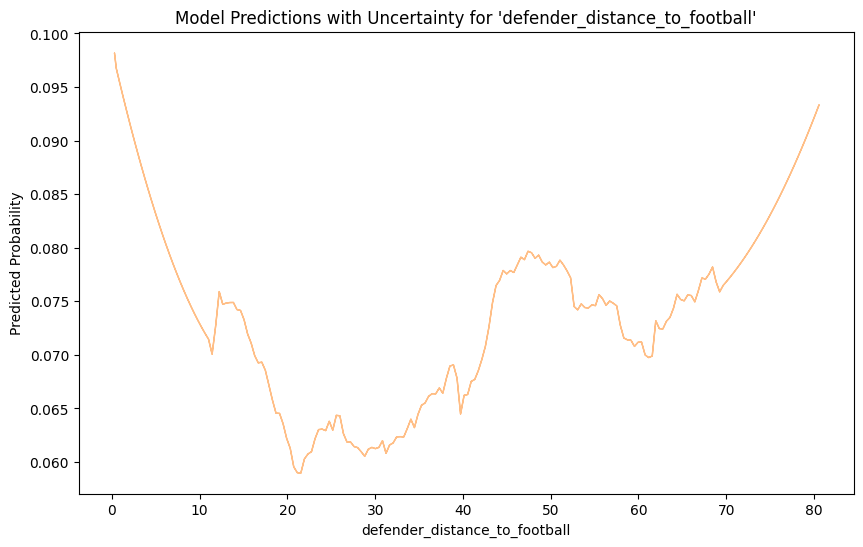

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


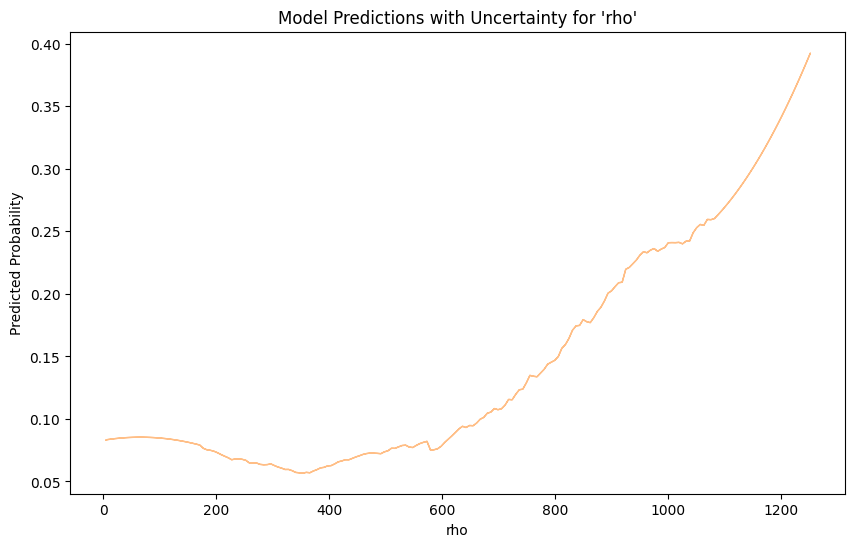

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


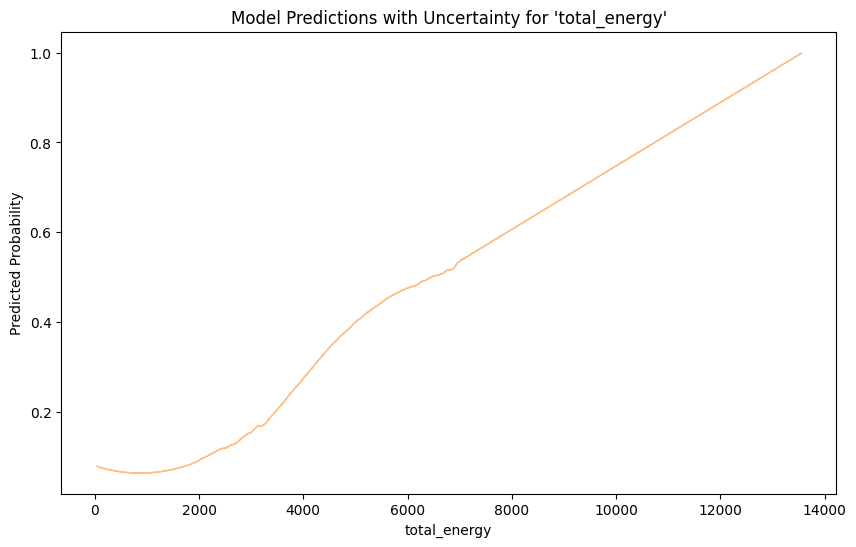

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


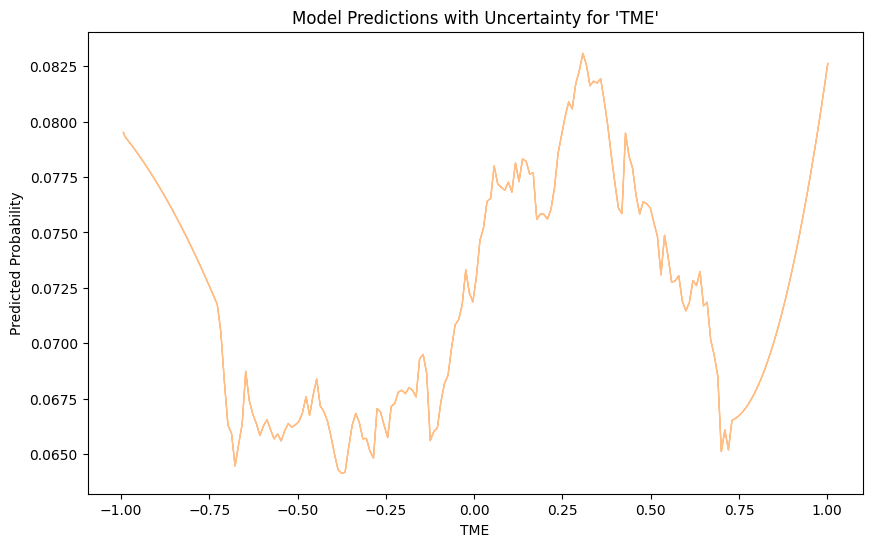

In [35]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Generate PPC for the logistic model
#with model_tackle_event:
#    ppc = pm.sample_posterior_predictive(trace_tackle_event)

# Function to plot HDI for a given feature
def plot_hdi_for_feature(feature_name, ppc, data_frame):
    # Extracting the feature values
    feature_values = data_frame[feature_name].values

    # Extracting the posterior predictive samples
    predicted_probs = ppc.posterior_predictive.y_obs.mean(dim=["chain", "draw"]).values
    predicted_probs = np.ravel(predicted_probs)
    # Reshaping the posterior samples to 2D array for HDI plotting
    posterior_pred_2d = predicted_probs.reshape(-1, predicted_probs.shape[-1])

    # Sorting the feature values and the corresponding posterior predictions
    sorted_indices = np.argsort(feature_values)
    sorted_feature_values = feature_values[sorted_indices]
    sorted_posterior_pred = posterior_pred_2d[:, sorted_indices]

    # Plotting the HDI
    _, ax = plt.subplots(figsize=(10, 6))
    az.plot_hdi(sorted_feature_values, sorted_posterior_pred, ax=ax, hdi_prob=0.5)

    # Customizing the plot
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Predicted Probability")
    ax.set_title(f"Model Predictions with Uncertainty for '{feature_name}'")
    plt.show()

# List of features to plot
features_to_plot = ["defender_carrier_dist", "defender_distance_to_football", "rho", "total_energy", "TME"]

# Plotting HDI for each feature
for feature in features_to_plot:
    plot_hdi_for_feature(feature, ppc, merged4)


In [148]:
ppc.keys

<bound method Mapping.keys of Inference data with groups:
	> >

In [ ]:
# BART model
RANDOM_SEED = 1000

import pymc as pm
import pymc_bart as pmb  # Make sure pymc_bart is installed

# Assuming merged4 and its columns are already defined
X = merged4_clean[['defender_carrier_dist', 'defender_distance_to_football', 'rho', 'force', 'TME', 'total_energy']].values
y = merged4_clean['tackle_event'].values

with pm.Model() as bart_tackle_event:
    # BART prior
    μ = pmb.BART("μ", X, y, m=25)  # m is the number of trees, adjust as needed

    # Logistic link function
    p = pm.math.sigmoid(μ)

    # Bernoulli likelihood for binary outcome
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # Sampling with specified number of draws
    trace_tackle_event_bart = pm.sample(1000, random_seed=RANDOM_SEED)

# You can then analyze the trace as needed


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
!pip install pymc-bart

In [ ]:
# Assuming 'merged4' is your DataFrame

# Remove rows with any missing values
merged4_clean = merged4.dropna()

# Check the result
print("After removing missing values:")
print(merged4_clean.isnull().sum())


After removing missing values:
defender_carrier_dist            0
defender_distance_to_football    0
rho                              0
force                            0
TME                              0
tackle_event                     0
total_energy                     0
is_defensive_player              0
dtype: int64


In [ ]:
az.plot_posterior(trace_tackle_event_bart)


In [ ]:
az.plot_posterior(trace_tackle_event_bart)

In [ ]:
az.plot_rank(trace_tackle_event_bart)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)


In [ ]:
len_X_train = len(X_train)
len_X_test = len(X_test)
len_y_train = len(y_train)
len_y_test = len(y_test)

len_X_train, len_X_test, len_y_train, len_y_test


(228650, 97994, 228650, 97994)

In [ ]:
with bart_tackle_event:
    ppc = pm.sample_posterior_predictive(trace_tackle_event_bart)


In [ ]:
# Standardize the test data
X_test_std = (X_test - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)


In [ ]:
predicted_probs = ppc.posterior_predictive.y_obs.mean(dim=["chain", "draw"]).values
predicted_probs = np.ravel(predicted_probs)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Train-test split with indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_merged4, y_merged4, np.arange(len(y_merged4)), test_size=0.3, random_state=42)

# Assuming you already have 'predicted_probs' from your BART model

# Select predicted probabilities for the test set
predicted_probs_test = predicted_probs[test_indices]

# Check lengths to ensure compatibility
print("Length of predicted probabilities for test set:", len(predicted_probs_test))
print("Length of test labels:", len(y_test))

# Calculate ROC AUC if lengths match
if len(predicted_probs_test) == len(y_test):
    fpr, tpr, _ = roc_curve(y_test, predicted_probs_test)
    roc_auc = auc(fpr, tpr)
    print('ROC AUC Score:', roc_auc)
else:
    print("The lengths of predicted probabilities and test labels do not match.")


Length of predicted probabilities for test set: 97994
Length of test labels: 97994
ROC AUC Score: 0.620225744942988


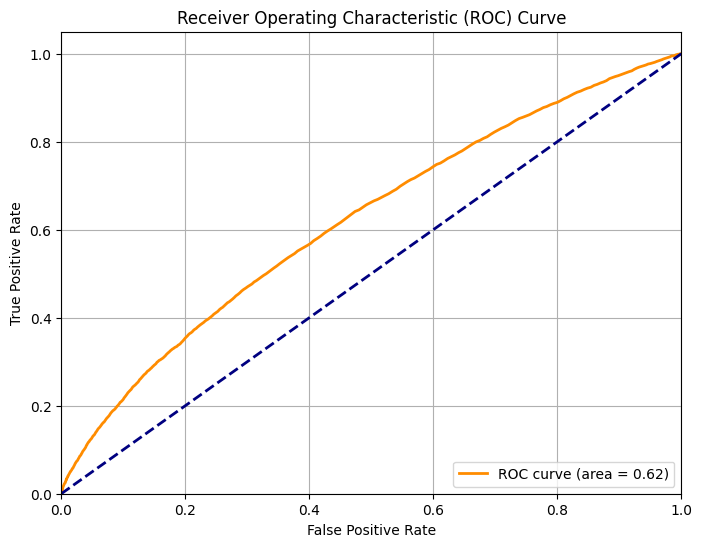

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
az.plot_trace(trace_tackle_event_bart, var_names=['μ'])

In [ ]:
import numpy as np

# Assuming 'predicted_probs' contains your model's predicted probabilities for the test set
binary_predictions = np.where(predicted_probs_test > 0.13, 1, 0)

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, binary_predictions)


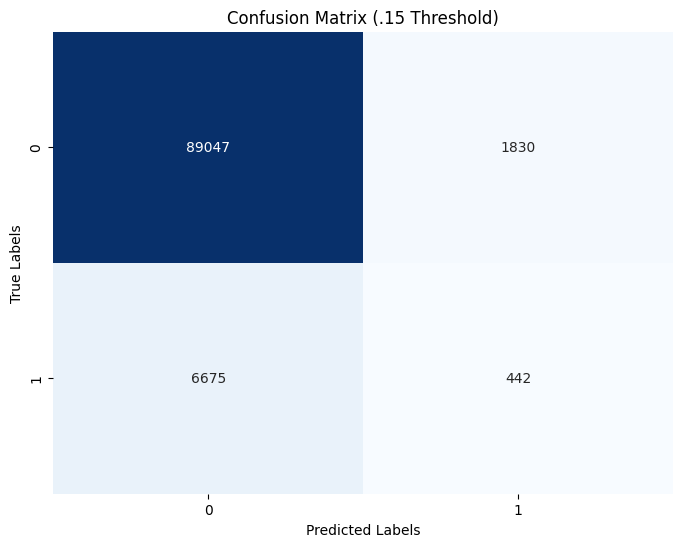

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (.15 Threshold)')
plt.show()


In [ ]:
posterior_predictions = ppc.posterior_predictive.y_obs.values


In [ ]:
mean_prediction = np.mean(posterior_predictions, axis=(0, 1))  # mean across chains and draws
lower_bound, upper_bound = np.percentile(posterior_predictions, [2.5, 97.5], axis=(0, 1))  # 95% credible interval


In [ ]:
# For example, selecting the first 100 data points
subset_index = np.arange(100)
mean_pred_subset = mean_prediction[subset_index]
lower_bound_subset = lower_bound[subset_index]
upper_bound_subset = upper_bound[subset_index]


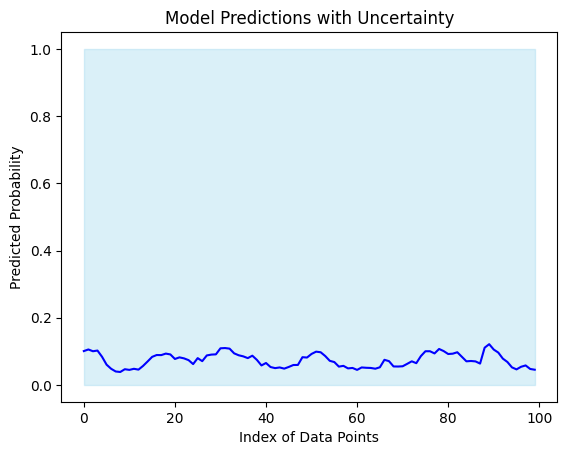

In [ ]:
plt.fill_between(subset_index, lower_bound_subset, upper_bound_subset, color='skyblue', alpha=0.3)  # Uncertainty area
plt.plot(subset_index, mean_pred_subset, color='blue')  # Mean prediction
plt.xlabel('Index of Data Points')
plt.ylabel('Predicted Probability')
plt.title('Model Predictions with Uncertainty')
plt.show()


In [ ]:
# Extract the posterior predictive samples for 'y_obs'
posterior_samples = ppc.posterior_predictive.y_obs.values
# Apply sigmoid function and calculate the mean across samples
posterior_probs = pm.math.sigmoid(posterior_samples).mean(axis=(0, 1))


In [ ]:
# Extracting posterior predictive samples
# Replace 'y_obs' with the appropriate key if different
posterior_samples = ppc.posterior_predictive.y_obs.values


In [ ]:
import numpy as np

# Sigmoid function to convert log-odds to probabilities
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Apply sigmoid function if necessary
posterior_probs = sigmoid(posterior_samples)


In [ ]:
# Calculating mean probabilities
# This assumes posterior_probs is a 3D array with shape (chains, draws, observations)
posterior_probs_np = np.mean(posterior_probs, axis=(0, 1))


In [ ]:
# Ensure posterior_probs_np is a 1D array
posterior_probs_np = np.ravel(posterior_probs_np)

# Print shape and data type for verification
print("Shape of posterior_probs_np:", posterior_probs_np.shape)
print("Data type of posterior_probs_np:", posterior_probs_np.dtype)


Shape of posterior_probs_np: (326644,)
Data type of posterior_probs_np: float64


In [ ]:
feature_for_plotting = merged4_clean['force'].values


In [ ]:
feature_for_plotting.shape

(326644,)

In [ ]:
posterior_predictive_samples = ppc.posterior_predictive["y_obs"].values


/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


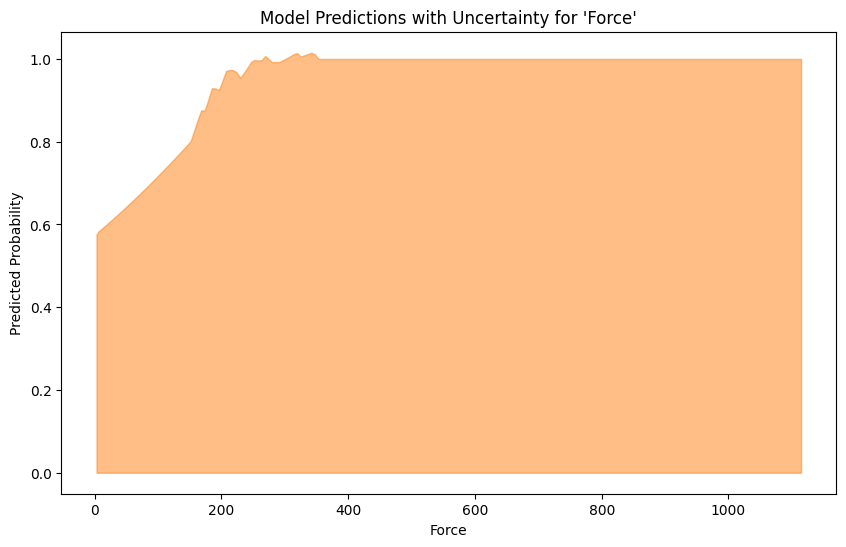

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Extracting the posterior predictive samples from the InferenceData object
# Here we assume 'y_obs' is the variable name in the posterior predictive group
posterior_predictive_samples = ppc.posterior_predictive["y_obs"].values

# posterior_predictive_samples is a 3D array: (chains, draws, observations)
# We compute the mean across the chains and draws to get the mean prediction for each observation
mean_posterior_pred = np.mean(posterior_predictive_samples, axis=(0, 1))

# For HDI, we need the full distribution, so we keep the chains and draws
# We reshape the samples to a 2D array: (chains * draws, observations) for the HDI plot
posterior_pred_2d = posterior_predictive_samples.reshape(-1, posterior_predictive_samples.shape[-1])

# feature_for_plotting should correspond to the 'force' variable in your dataset
feature_for_plotting = merged4_clean["force"].values

# Ensure that the 'force' feature is sorted alongside the predictions
# This is necessary for HDI plotting
sorted_indices = np.argsort(feature_for_plotting)
sorted_force = feature_for_plotting[sorted_indices]
sorted_posterior_pred = posterior_pred_2d[:, sorted_indices]

# Now we plot the HDI
_, ax = plt.subplots(figsize=(10, 6))

# Use the sorted 'force' feature and corresponding predictions
az.plot_hdi(sorted_force, sorted_posterior_pred, ax=ax, hdi_prob=0.95)

# Customizing the plot
ax.set_xlabel("Force")
ax.set_ylabel("Predicted Probability")
ax.set_title("Model Predictions with Uncertainty for 'Force'")
plt.show()


In [ ]:
merged4_clean

,defender_carrier_dist,defender_distance_to_football,rho,force,TME,tackle_event,total_energy,is_defensive_player
0,11.013632,9.256266,136.06768,418.07892,-0.166554,0.0,129.529087,1.0
1,10.246878,8.688046,195.32296,486.11276,0.290935,0.0,229.789344,1.0
2,9.464486,8.500617,242.50772,460.87440,-0.306490,0.0,322.187614,1.0
3,8.646531,8.557009,296.27640,424.66284,-0.697373,0.0,449.600623,1.0
4,7.812074,8.590053,334.68260,350.04508,0.459627,0.0,551.141015,1.0
...,...,...,...,...,...,...,...,...
326639,30.800157,32.017988,657.02812,265.25980,0.663869,0.0,2123.915258,1.0
326640,30.642338,30.584469,690.69571,271.38118,0.697887,0.0,2346.878148,1.0
326641,30.491778,29.848301,718.24192,244.85520,-0.050686,0.0,2536.414880,1.0
326642,30.391064,28.882177,742.72744,229.55175,0.905457,0.0,2711.475750,1.0


/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


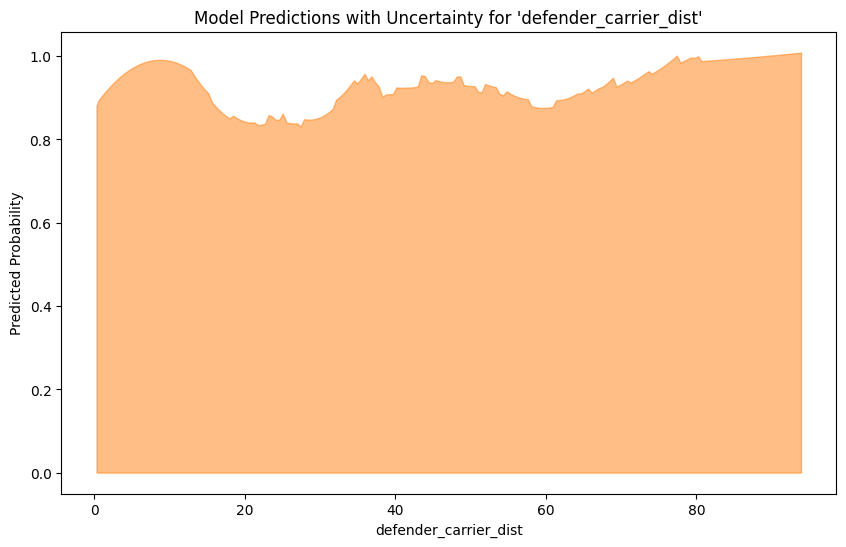

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


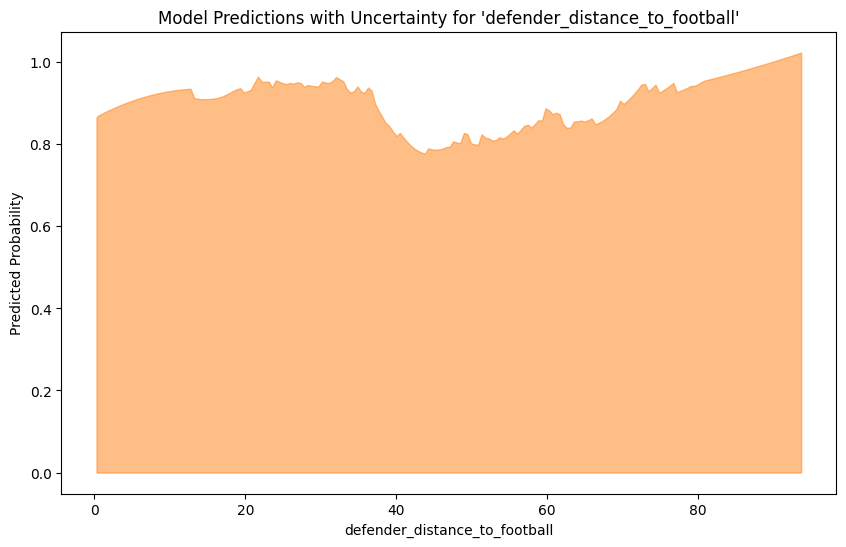

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


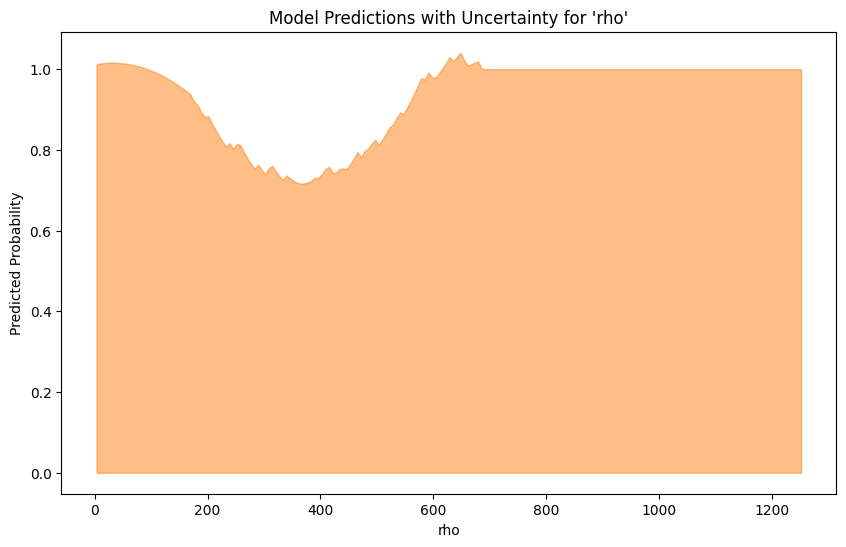

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


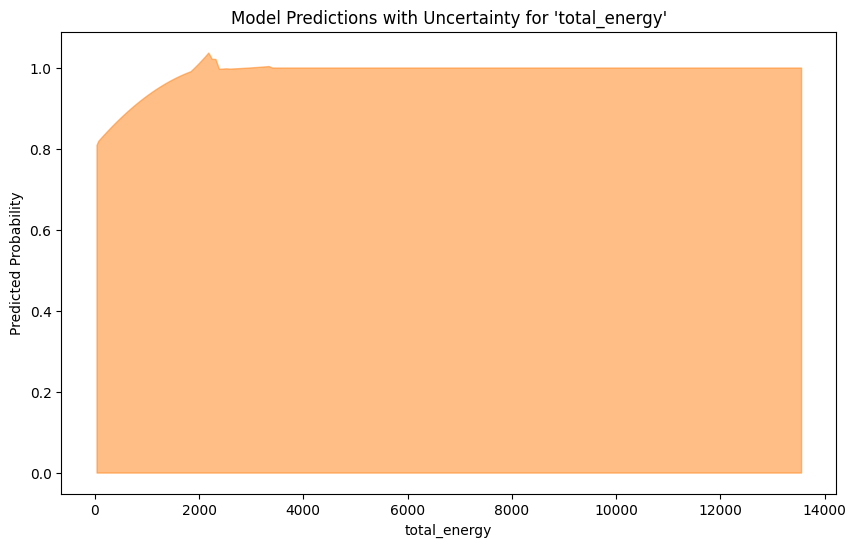

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


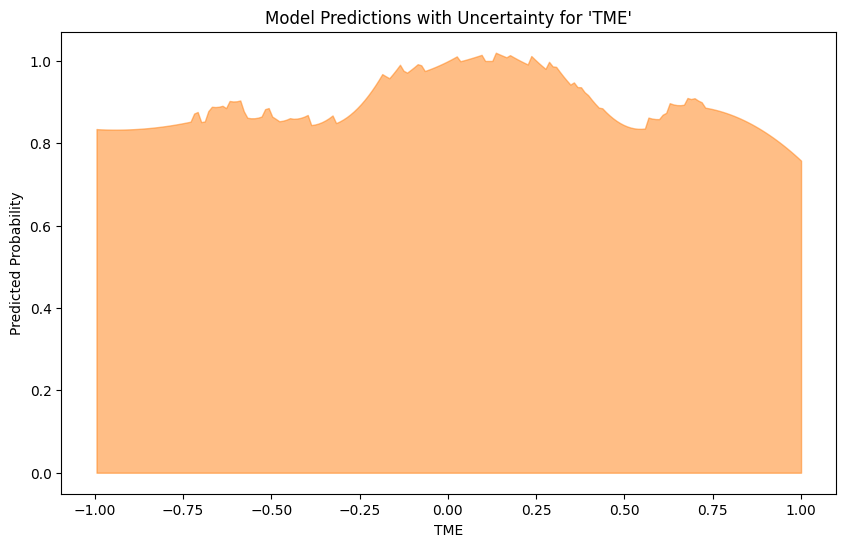

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Function to plot HDI for a given feature
def plot_hdi_for_feature(feature_name, ppc, merged4_clean):
    # Extracting the feature values
    feature_values = merged4_clean[feature_name].values

    # Extracting the posterior predictive samples
    posterior_predictive_samples = ppc.posterior_predictive["y_obs"].values

    # Reshaping the posterior samples to 2D array for HDI plotting
    posterior_pred_2d = posterior_predictive_samples.reshape(-1, posterior_predictive_samples.shape[-1])

    # Sorting the feature values and the corresponding posterior predictions
    sorted_indices = np.argsort(feature_values)
    sorted_feature_values = feature_values[sorted_indices]
    sorted_posterior_pred = posterior_pred_2d[:, sorted_indices]

    # Plotting the HDI
    _, ax = plt.subplots(figsize=(10, 6))
    az.plot_hdi(sorted_feature_values, sorted_posterior_pred, ax=ax, hdi_prob=0.95)

    # Customizing the plot
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Predicted Probability")
    ax.set_title(f"Model Predictions with Uncertainty for '{feature_name}'")
    plt.show()

# List of features to plot
features_to_plot = [
    "defender_carrier_dist",
    "defender_distance_to_football",
    "rho",
    "total_energy",
    "TME"
]

# Plotting HDI for each feature
for feature in features_to_plot:
    plot_hdi_for_feature(feature, ppc, merged4_clean)


In [ ]:
rhat = az.rhat(trace_tackle_event_bart)


In [ ]:
print(rhat)